## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

The images for camera calibration are stored in the folder called ***camera_cal***. In this part, there are two main steps to this process: use chessboard images to image points and object points, and then use the OpenCV functions ***cv2.calibrateCamera()*** and ***cv2.undistort()*** to compute the calibration and undistortion.

### 1.1 Store all the images and corners to them to two lists: *objpoints* and *imgpoints*

If the image of the chessborad is not taken properly(9x6), skip the image

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# prepare object points
nx = 9#the number of inside corners in x
ny = 6#the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = os.listdir('camera_cal')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread('camera_cal/'+fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        pass
        print("skip: ",fname)

skip:  calibration1.jpg
skip:  calibration4.jpg
skip:  calibration5.jpg


### 1.2 Compute the camera calibration matrix and distortion coefficients

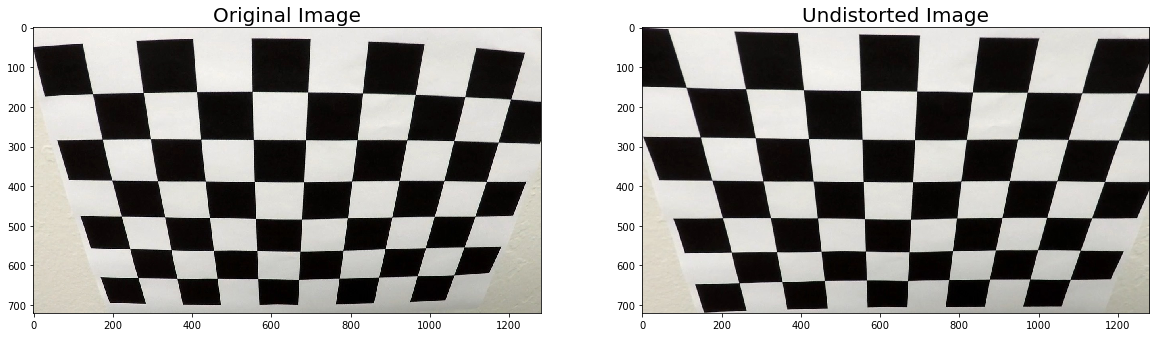

In [2]:
import pickle
%matplotlib inline
import matplotlib.image as mpimg

# Test undistortion on an image
img = mpimg.imread('test.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

## 2. Apply a distortion correction to raw images.

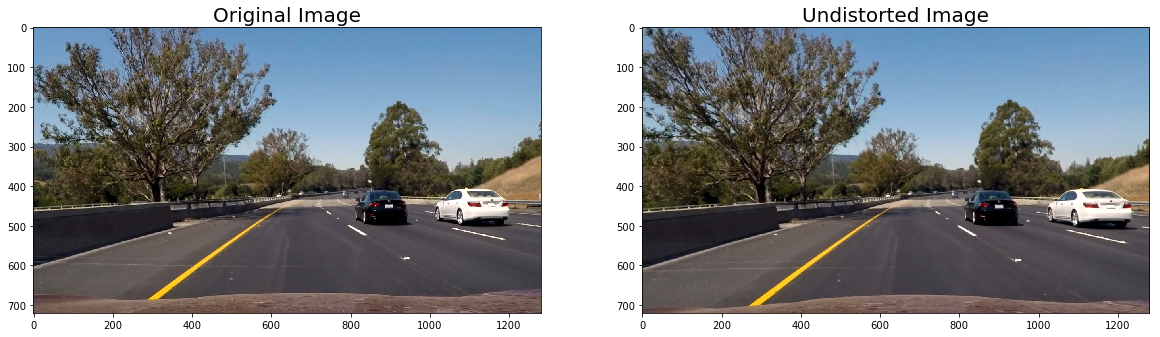

In [3]:
# Define a function to do distortion correction to raw images
def distCorrection(image):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

# test an image from the 'test_images' folder
img = mpimg.imread('test_images/test6.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(distCorrection(img))
ax2.set_title('Undistorted Image', fontsize=20)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

### 3.1 Using gradient threshold (sobel operator, direction of the gradient) to get a binary result from multiple thresholds

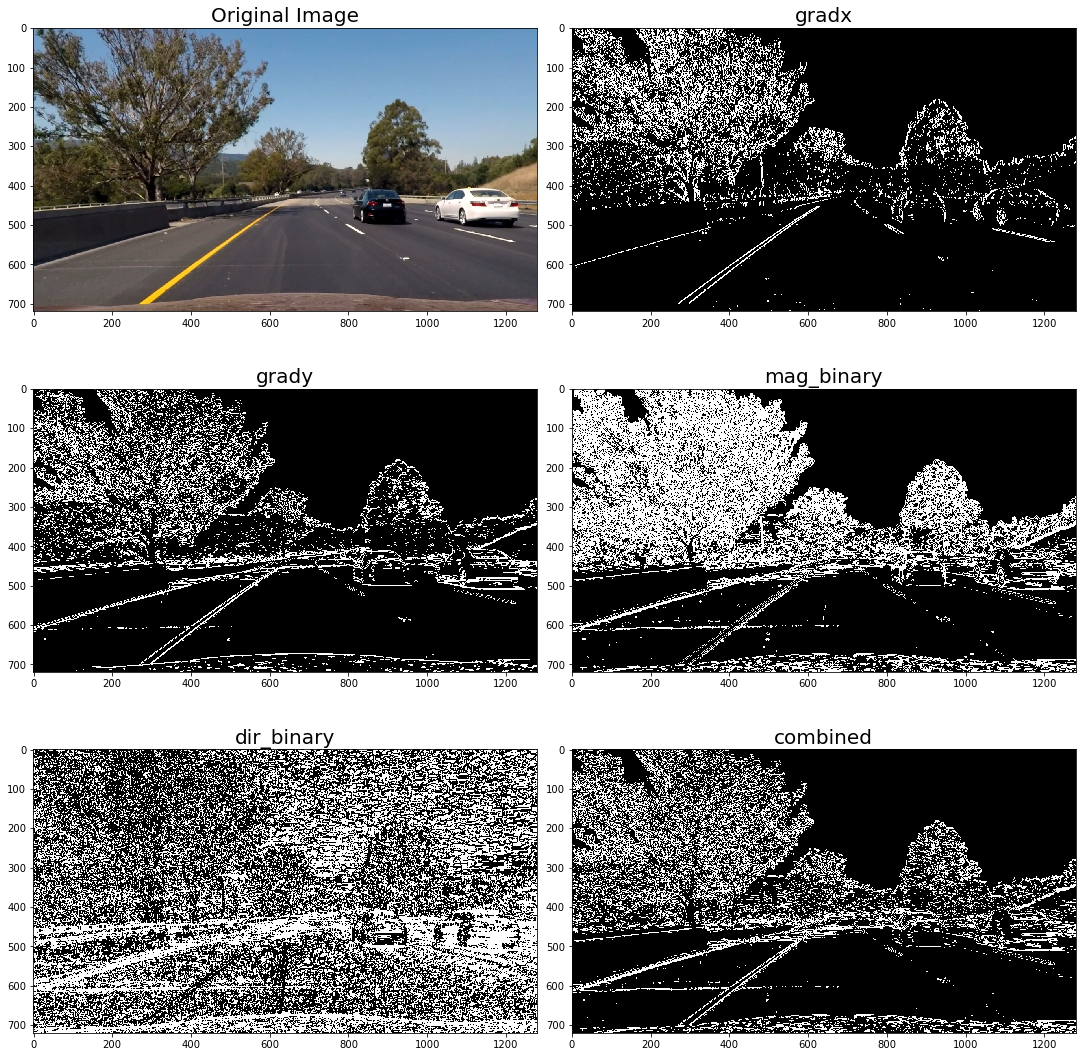

In [4]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,sobel_kernel)
    # 3) Calculate the magnitude
    sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output


#test the former image to find a best combination to it
img = distCorrection(img)

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20,100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20,100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(10,60))
dir_binary = dir_threshold(img, sobel_kernel=5, thresh=(1,1.6))

#Multiple thresholds combination:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gradx,cmap='gray')
ax2.set_title('gradx', fontsize=20)
ax3.imshow(grady,cmap='gray')
ax3.set_title('grady', fontsize=20)
ax4.imshow(mag_binary,cmap='gray')
ax4.set_title('mag_binary', fontsize=20)
ax5.imshow(dir_binary,cmap='gray')
ax5.set_title('dir_binary', fontsize=20)
ax6.imshow(combined,cmap='gray')
ax6.set_title('combined', fontsize=20)
#plt.subplots_adjust(left=0., right=1, top=1, bottom=0)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### 3.2 HLS and Color Thresholds

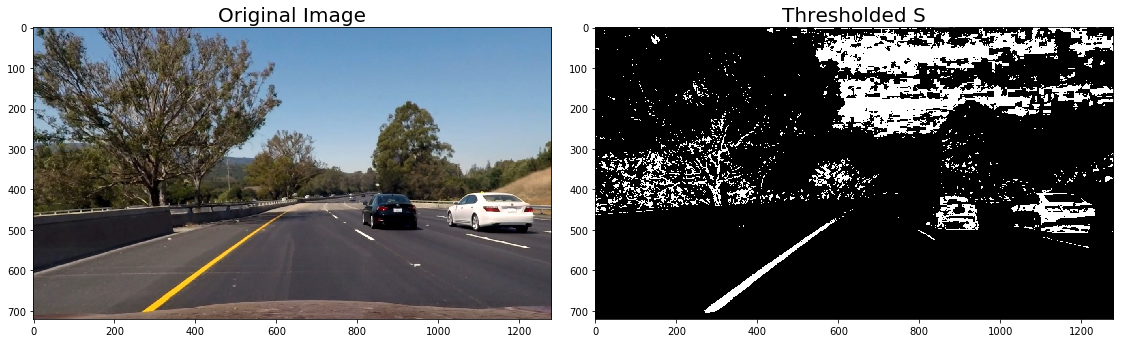

In [5]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary
    
hls_binary = hls_select(img, thresh=(110, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 3.3 Combine S Channel and Gradient Thresholds

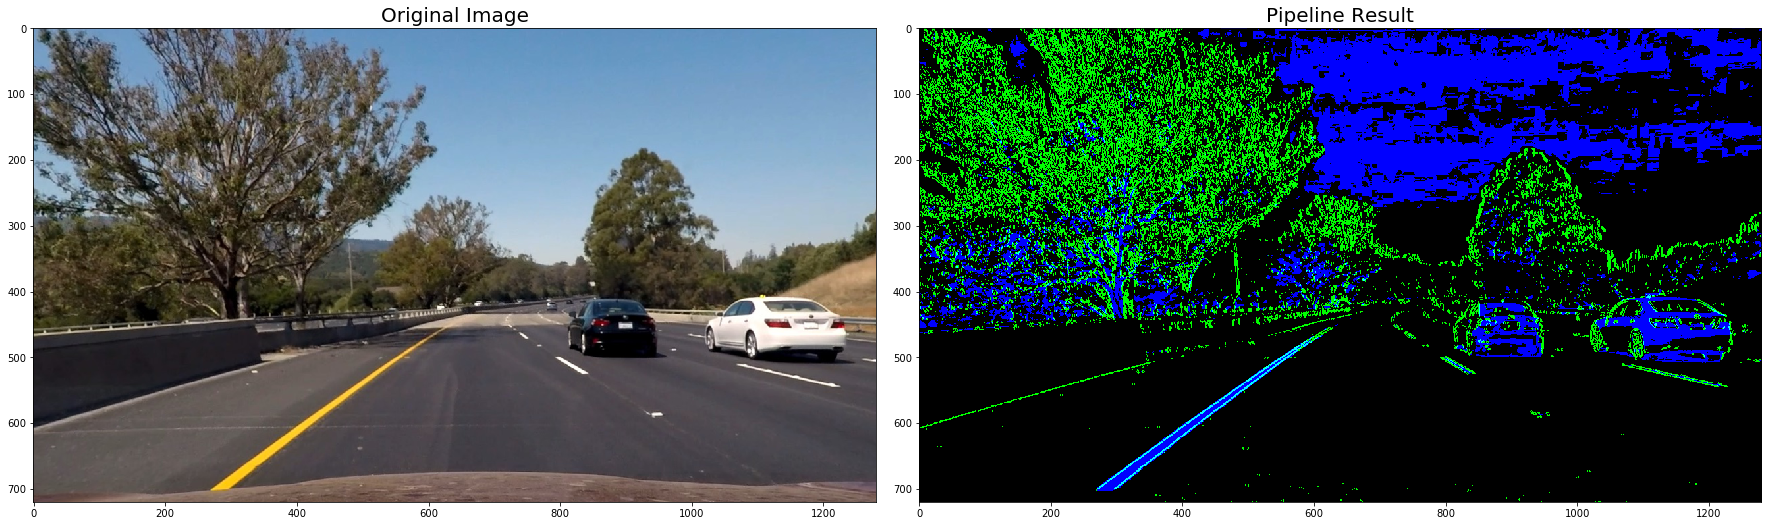

In [6]:
def pipeline(img, sobel_kernel=3, s_thresh=(110, 255), sx_thresh=(20, 100), sy_thresh=(20,100), magnitude_thresh=(10,60), dir_thresh=(0.7,1.3)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=sy_thresh)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=magnitude_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=dir_thresh)
    #Multiple thresholds combination:
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1

    
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), combined, s_binary))
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

### 4.1 Test for straight lane lines

(720, 1280, 3)


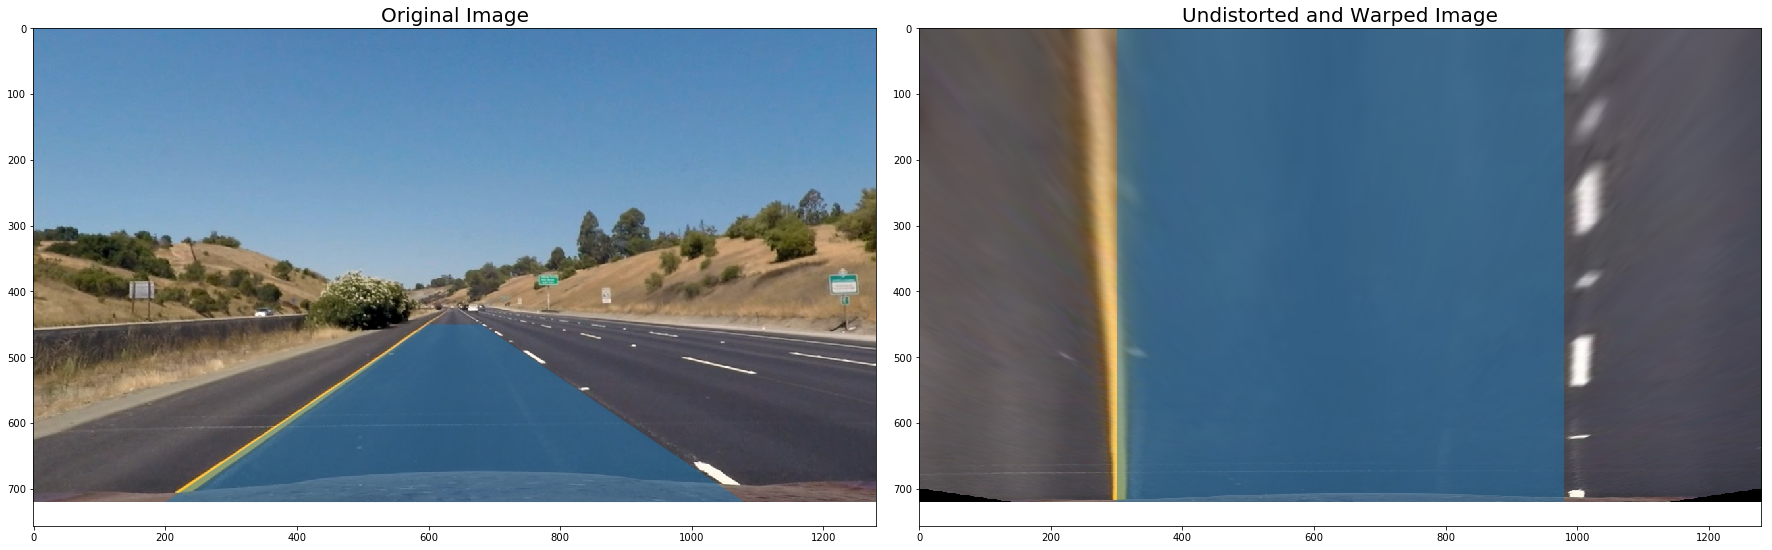

In [7]:
def bird_eye(img):
    if True:
        offset = 100
        img_size = (img.shape[1], img.shape[0])
        #define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([[200,720],[600,450],[680,450],[1080,720]])
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[300,720],[300,0],[980,0],[980,720]])
        #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(img, M, img_size)
    return warped, M

img = mpimg.imread('test_images/straight_lines1.jpg')
img = distCorrection(img)
print(img.shape)
top_down, perspective_M = bird_eye(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax1.fill_between([200,600,680,1080,200],[720,450,450,720,720], alpha = 0.5)

ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=20)
ax2.fill_between([300,300,980,980,300],[720,0,0,720,720], alpha = 0.5)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 4.2 Apply to threshold images

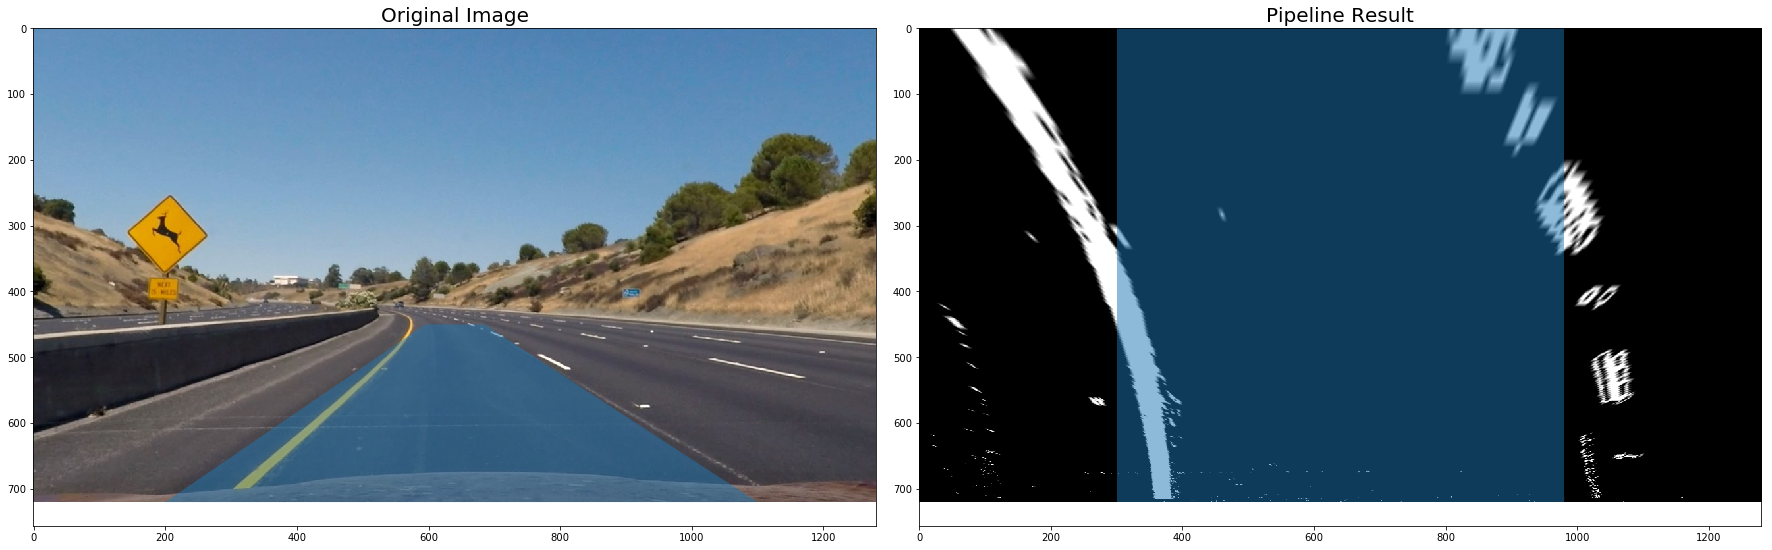

In [8]:
img = mpimg.imread('test_images/test2.jpg')

def transformation(img):
    img = distCorrection(img)
    result = pipeline(img)
    result2 = np.zeros_like(result[:,:,0])
    result2[(result[:,:,1]==1)|(result[:,:,2]==1)] = 1
    top_down, perspective_M = bird_eye(result2)
    return top_down

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(distCorrection(img))
ax1.set_title('Original Image', fontsize=20)
ax1.fill_between([200,595,685,1100,200],[720,450,450,720,720], alpha = 0.5)

ax2.imshow(transformation(img),cmap='gray')
ax2.set_title('Pipeline Result', fontsize=20)
ax2.fill_between([300,300,980,980,300],[720,0,0,720,720], alpha = 0.5)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5. Detect lane pixels and fit to find the lane boundary

### 5.1 Take a histogram along all the columns in the lower half of the binary image

(1280,)


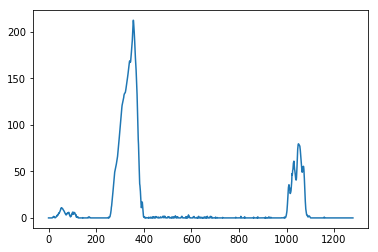

In [9]:
import numpy as np
img = mpimg.imread('test_images/test2.jpg')
binary_warped = transformation(img)
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
print(histogram.shape)
plt.plot(histogram)

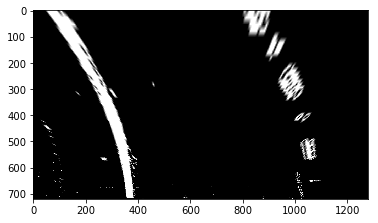

In [10]:
plt.imshow(binary_warped,cmap='gray')

### 5.2 Implement Sliding Windows and Fit a Polynomial

[ -4.39370954e-04   7.24063091e-01   8.20699488e+01] [ -5.61270935e-04   6.81802952e-01   8.41187345e+02]


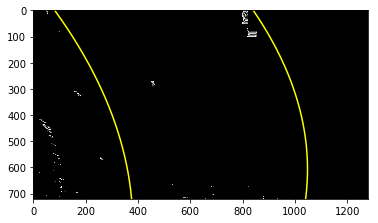

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#print('leftx_base: ',leftx_base)
#print('rightx_base: ', rightx_base)
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
#print('window_height: ', window_height)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)



#Visualization

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print(left_fit, right_fit)

In [12]:
#fit a polynomial
def polynomial_sliding_windows(img):
    binary_warped = transformation(img)
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #print('leftx_base: ',leftx_base)
    #print('rightx_base: ', rightx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    #print('window_height: ', window_height)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

img = mpimg.imread('test_images/test2.jpg')
l,r = polynomial_sliding_windows(img)
print(l,r)
print(left_fit, right_fit)

[ -4.39370954e-04   7.24063091e-01   8.20699488e+01] [ -5.61270935e-04   6.81802952e-01   8.41187345e+02]
[ -4.39370954e-04   7.24063091e-01   8.20699488e+01] [ -5.61270935e-04   6.81802952e-01   8.41187345e+02]


### 5.3 Skip the sliding windows step once you know where the lines are

In [13]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

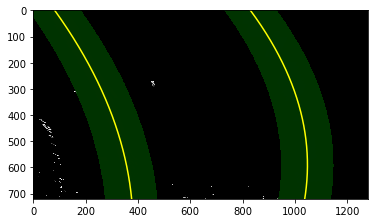

In [14]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 5.4 Sliding Window Search

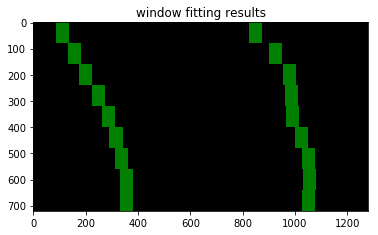

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
img = mpimg.imread('test_images/test2.jpg')
warped = transformation(img)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## 6. Determine the curvature of the lane and vehicle position with respect to center

### 6.1 Radius of Curvature (sampled by generated fake data)

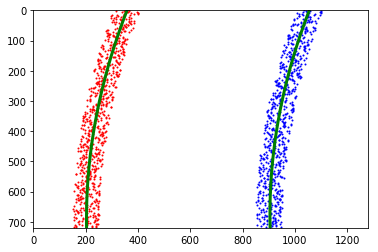

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 1
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [17]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
print('y_eval:', y_eval)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('left curvature: ',left_curverad)
print('right curvature: ', right_curverad)
# Example values: 1926.74 1908.48

y_eval: 719.0
left curvature:  1540.82354379
right curvature:  1517.1431949


In [18]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

505.840801179 m 497.68349126 m


### 6.2 Radius of Curvature in Real Wrold Images

In [40]:
def radius_curve(img):
    left_fit,right_fit = polynomial_sliding_windows(img)
    ploty = np.linspace(0, 719, num=720)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    #Calculate the offset to the lane center
    offset = ((rightx[-1]+leftx[-1])/2-640)*xm_per_pix
    if offset >=0 :
        center = 'left'
    else:
        center = 'right'
        offset = -1*offset
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = (left_curverad+right_curverad)/2
    # Now our radius of curvature is in meters
    return offset, center, curverad
    
img = mpimg.imread('test_images/test1.jpg')
offset, center, curverad = radius_curve(img)
print('Radius of Curvature: {0:.2f}m'.format(curverad))
print('Vehicle is {0:.2f}m {1} of center'.format(offset,center))

Radius of Curvature: 1176.02m
Vehicle is 0.24m left of center


## 7. Warp the detected lane boundaries back onto the original image

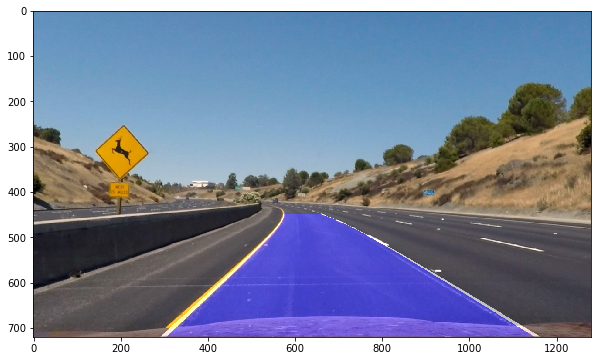

In [42]:

def plot_lane_boundaries(img):
    
    left_fit,right_fit = polynomial_sliding_windows(img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Mask of lanes
    lane_mask = np.zeros_like(img)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    left_lane=np.int_(pts_left.squeeze())
    right_lane = np.int_(pts_right.squeeze())

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lane_mask, np.int_([pts]), (0,0,255))

    cv2.polylines(lane_mask, [left_lane], 0, (255,255,255),thickness =10)
    cv2.polylines(lane_mask, [right_lane], 0, (255,255,255),thickness =10)

    #Apply the rectify binary image back to the perspective transform 
    src = np.float32([[200,720],[600,450],[680,450],[1080,720]])
    dst = np.float32([[300,720],[300,0],[980,0],[980,720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    warped_back = cv2.warpPerspective(lane_mask, Minv, img_size, flags=cv2.INTER_LINEAR)
    #Add the warped_back lanes to image
    img = distCorrection(img)
    result = cv2.addWeighted(img, 1, warped_back, 0.5, 0)
    return result


img = mpimg.imread('test_images/test2.jpg')
plt.figure(figsize=(10,6))
plt.imshow(plot_lane_boundaries(img), interpolation='nearest',aspect='auto')

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

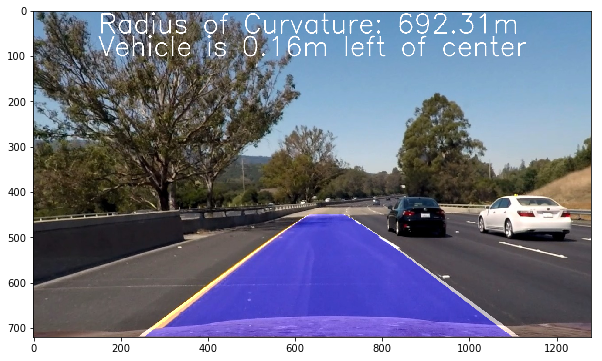

In [44]:
def process_image(img):
    offset, center, curverad = radius_curve(img)
    string_a = 'Radius of Curvature: {0:.2f}m'.format(curverad)
    string_b = 'Vehicle is {0:.2f}m {1} of center'.format(offset,center)

    result = plot_lane_boundaries(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,string_a,(150,50), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,string_b,(150,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result
    
img = mpimg.imread('test_images/test6.jpg')
result = process_image(img)
plt.figure(figsize=(10,6))
plt.imshow(result, interpolation='nearest',aspect='auto')

In [45]:
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile('project_video_processed.mp4', audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [12:41<00:00,  1.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 35min 37s, sys: 4min 20s, total: 39min 58s
Wall time: 12min 42s


### See the final output video *project_video_processed.mp4* outside the folder

## 9. Discussion


The most tricky part is how to find the most robust threshold binary image due to the complex environments. Using brightness and darkness to find lanes is often unstable, introducing HLS color and gradient(both x and y directions) to the lane-finding algorighm would solve most of the problem. However, **"5.2 Implement Sliding Windows and Fit a Polynomial"** part is based on the hypothesis that the lanes are continuous, which requires no obstruct (like other vehicles painted yellow or white) on the lane lines. 